In [42]:
##Load packages

import pandas as pd
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt



In [43]:
#Load pre-processed datasets

tomtom = pd.read_parquet("tomtom_data.parquet")
vessels = pd.read_parquet("vessels_data.parquet")
weather = pd.read_csv("SAIL_Amsterdam_10min_Weather_2025-08-20_to_2025-08-24.csv")
sensors_location = pd.read_csv("sensor-location.xlsx - Sheet1.csv", ).rename(columns={"Objectummer": "sensor_id"})
sensors = pd.read_csv("sensordata_SAIL2025.csv", parse_dates=["timestamp"])


In [44]:
#Mutations sensor information

#Replace , by r . so it can be used in calculations
sensors_location["Effectieve breedte"] = (
    sensors_location["Effectieve breedte"]
    .astype(str)
    .str.replace(",", ".")
    .astype(float)
)

# Retrieve latitude and longitude information in separate columns
sensors_location[["lat", "lon"]] = (
    sensors_location["Lat/Long"]
    .str.replace(" ", "")  
    .str.split(",", expand=True)
    .astype(float)
)

#Divide all counts by the effective width of the sensor location
width = sensors_location.set_index("sensor_id")["Effectieve breedte"].to_dict()

for col in sensors.columns:
    if "_" in col:  
        sensor_id = col.split("_")[0]
        if sensor_id in width:
            sensors[col] = sensors[col] / (width[sensor_id])



In [45]:
## Mutations weather data

# replace 24 by 00 to account for UTC datetime
weather["DateTime"] = weather["DateTime"].str.replace(" 24:", " 00:", regex=False)

# Convert to UTC datetime and round up for every 3 minutes
weather["DateTime"] = pd.to_datetime(weather["DateTime"], format="%Y%m%d %H:%M")
weather = weather.set_index("DateTime")
weather_3min = weather.resample("3min").nearest()
weather_3min = weather_3min.reset_index()

In [46]:
## Mutations vessel data

# Convert to UTC datetime and round up for every 3 minutes
vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], utc=True, errors="coerce")
vessels["timestamp"] = vessels["timestamp"].dt.floor("3min")

#Take average longitude and latitude over 3 minutes and srot by datetime
vessels = (
    vessels.groupby(["timestamp", "imo-number"], as_index=False)
    .agg({
        "lat": "mean",
        "lon": "mean",
        "length": "first"
    })
)


In [47]:
##Combining vessel, weather and sensor data

#Ensure compatitibility datetime dataset
vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], utc=True)
sensors["timestamp"] = pd.to_datetime(sensors["timestamp"], utc=True)
weather_3min["DateTime"] = pd.to_datetime(weather_3min["DateTime"], utc=True) 

#Merge datasets
combined = sensors.merge(vessels, on="timestamp", how="inner")
combined = combined.merge(
    weather_3min.rename(columns={"DateTime": "timestamp"})[
        ["timestamp", "Temperature_°C", "Humidity_%", "Rain_mm"]
    ],
    on="timestamp",
    how="left"   # keep all rows from sensors+vessels even if weather missing
)



In [ ]:
#Calculate distance sensors to vessels every three minutes

# Merge sensor coordinates into the combined dataframe
lat_lookup = sensors_location.set_index("sensor_id")["lat"].to_dict()
lon_lookup = sensors_location.set_index("sensor_id")["lon"].to_dict()

#Haversine function for accurate distance calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius (meters)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


# Compute distance for every vessel at every timestamp to every sensor 
for _, sensor in sensors_location.iterrows():
    sensor_id = sensor["sensor_id"]
    s_lat = sensor["lat"]
    s_lon = sensor["lon"]
    
    dist_col = f"dist_{sensor_id}" 
    combined[dist_col] = haversine(s_lat, s_lon, combined["lat"], combined["lon"])


In [49]:
# ##Deep learning model (Using Torch)


# # --- Split train/test by time ---
# train_data = combined[combined["timestamp"].dt.hour < 13]
# test_data  = combined[combined["timestamp"].dt.hour >= 13]

# feature_cols = (
#     ["Temperature_°C", "Humidity_%", "Rain_mm", "length"]
#     + [c for c in combined.columns if c.startswith("dist_")]
# )

# target_cols = [c for c in combined.columns if c.startswith("CMSA-")]



# # --- Clean distances ---
# for col in feature_cols:
#     if col.startswith("dist_"):
#         combined[col] = combined[col].clip(0, 10000)  # cap at 10 km

# # --- Normalize input features using z-score scaling ---
# scaler = StandardScaler()
# train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
# test_data[feature_cols] = scaler.transform(test_data[feature_cols])

# # --- Prepare tensors ---
# X_train = torch.tensor(train_data[feature_cols].values, dtype=torch.float32)
# y_train = torch.tensor(train_data[target_cols].values, dtype=torch.float32)
# X_test  = torch.tensor(test_data[feature_cols].values, dtype=torch.float32)
# y_test  = torch.tensor(test_data[target_cols].values, dtype=torch.float32)

# # --- Define regression model ---
# class VesselSensorRegressor(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, output_dim)
#         )
#     def forward(self, x):
#         return self.model(x)

# model = VesselSensorRegressor(X_train.shape[1], y_train.shape[1])
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # --- Train ---
# train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

# for epoch in range(40):
#     model.train()
#     for xb, yb in train_loader:
#         optimizer.zero_grad()
#         pred = model(xb)
#         loss = loss_fn(pred, yb)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1:02d} | Train MSE: {loss.item():.6f}")

# # --- Evaluate and predict ---
# def evaluate_model(model, X, y_true):
#     model.eval()
#     with torch.no_grad():
#         preds = model(X)
#         mse = loss_fn(preds, y_true).item()
#         rmse = torch.sqrt(torch.mean((preds - y_true)**2)).item()
#         mae = torch.mean(torch.abs(preds - y_true)).item()
#         mape = torch.mean(torch.abs((preds - y_true) / (y_true + 1e-6))) * 100
#         ss_res = torch.sum((y_true - preds)**2)
#         ss_tot = torch.sum((y_true - torch.mean(y_true))**2)
#         r2 = (1 - ss_res / ss_tot).item()
#     return preds, mse, rmse, mae, mape.item(), r2

# preds, test_mse, test_rmse, test_mae, test_mape, test_r2 = evaluate_model(model, X_test, y_test)

# print(f"\n✅ Test Results:")
# print(f"   MSE:  {test_mse:.4f}")
# print(f"   RMSE: {test_rmse:.2f} people")
# print(f"   MAE:  {test_mae:.2f} people")
# print(f"   MAPE: {test_mape:.2f}%")
# print(f"   R²:   {test_r2:.3f}")






In [50]:
# # --- Save predictions ---
# pred_df = pd.DataFrame(preds, columns=[f"pred_{col}" for col in target_cols])
# pred_df["timestamp"] = test_data["timestamp"].values

# # --- Optional: also store actual values for comparison ---
# for col in target_cols:
#     pred_df[f"actual_{col}"] = test_data[col].values

# # --- Resample to 3-minute intervals ---
# pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"]).dt.round("3min")
# pred_df = (
#     pred_df
#     .set_index("timestamp")
#     .resample("3min")
#     .mean()
#     .reset_index()
# )

# # --- Save to CSV ---
# output_path = "predicted_sensor_values_3min.csv"
# pred_df.to_csv(output_path, index=False)

# print(f"✅ Predictions saved to: {output_path}")
# print(pred_df.head())


In [57]:
##Ridge model (SKlearn)

# Split data in training data (before 13:00) and test data (after 13:00)
train_data = combined[combined["timestamp"].dt.hour < 13]
test_data  = combined[combined["timestamp"].dt.hour >= 13]

# Define predictors
feature_cols = (
    ["Temperature_°C", "Humidity_%", "Rain_mm", "length"]
    + [c for c in combined.columns if c.startswith("dist_")]
)

#Define predictions
target_cols = [c for c in combined.columns if c.startswith("CMSA-")]

# Clean distances (cap at 1 Km, after which assume no influence)
for col in feature_cols:
    if col.startswith("dist_"):
        combined[col] = combined[col].clip(0, 1000)

# Prepare train/test sets
X_train = train_data[feature_cols].values
X_test  = test_data[feature_cols].values
y_train = train_data[target_cols].values
y_test  = test_data[target_cols].values

# Define Ridge regression pipeline with scaling
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=3.0, random_state=0))
])

# Wrap in TransformedTargetRegressor to account for only positive numbers
model = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    func=np.log1p,       
    inverse_func=np.expm1 
)

# Train model
model.fit(X_train, y_train)

# Predict on test set 
preds = model.predict(X_test)


Sample predictions: [[23.44303143 21.14683736 11.67413425 13.13932935 18.91471074 16.90274691
   4.88166526  9.55940223  5.71893183  2.18069062  6.71272937  4.99872645
  10.45883593  8.28210152  6.82318179  5.98801939 15.7549034   8.36903792
   9.49911895  7.49021382  5.87169788  5.69340522  1.31400756  2.07920291]
 [23.90424306 21.51657241 11.80365475 13.22533733 19.25098032 17.13655566
   4.94081155  9.6522928   5.80432193  2.1945706   6.71803443  5.06463593
  10.58442678  8.30008284  6.90770226  6.03383972 15.78619618  8.45536646
   9.58495864  7.53133264  5.81220281  5.62354256  1.31660509  2.08419492]
 [23.85057688 21.40005959 11.74338916 13.1394439  19.11996281 17.06466179
   4.92333453  9.62731052  5.77675674  2.19730455  6.74609993  5.05119628
  10.52041278  8.27197326  6.90175629  6.01741902 15.7231591   8.42845645
   9.56205673  7.55805075  5.98545226  5.79070566  1.3133176   2.07530816]
 [24.5239933  21.92539522 11.70740038 13.17605315 19.40012712 17.35440409
   5.05493594  

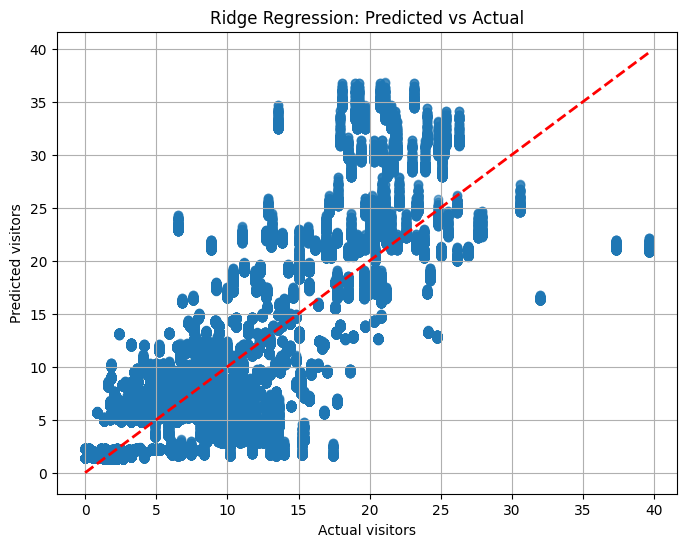

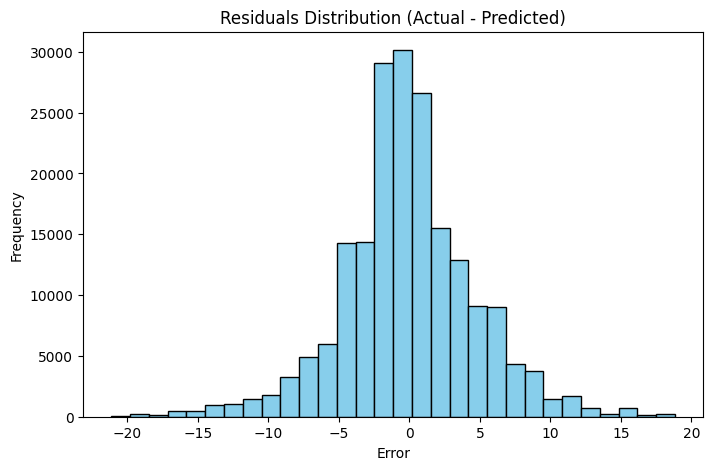

           category  importance  percentage
0  Vessel proximity    2.327932   78.279258
1           Weather    0.645949   21.720742


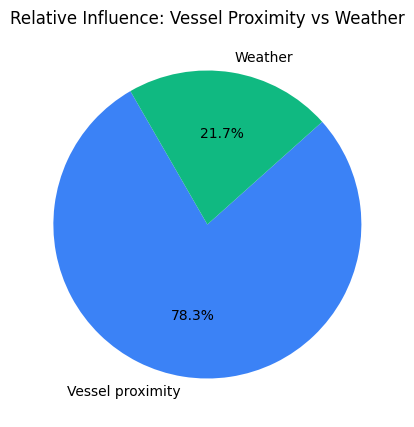

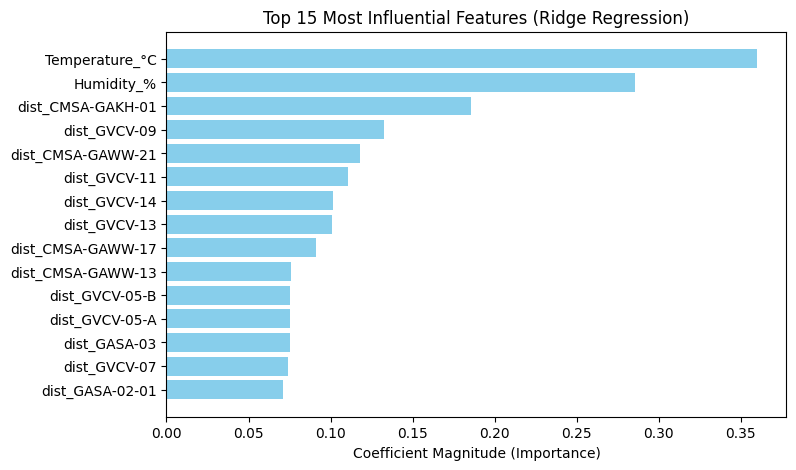

In [ ]:
##Visuals

# Compare to your test data (after inverse_transform)
sample_preds = model.predict(X_test[:5])
print("Sample predictions:", sample_preds)
print("Corresponding actuals:", y_test[:5])

# Evaluate performance 
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("✅ Ridge Model Results")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Optional: Compare average predictions ---
print("\n--- Mean Comparison ---")
print(f"Train target mean: {y_train.mean():.2f}")
print(f"Test  target mean: {y_test.mean():.2f}")
print(f"Pred  mean:        {preds.mean():.2f}")

# --- Visualization ---
plt.figure(figsize=(8,6))
plt.scatter(y_test.flatten(), preds.flatten(), alpha=0.6)
plt.xlabel("Actual visitors")
plt.ylabel("Predicted visitors")
plt.title("Ridge Regression: Predicted vs Actual")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.show()

# --- Residual plot ---
plt.figure(figsize=(8,5))
residuals = y_test.flatten() - preds.flatten()
plt.hist(residuals, bins=30, color='skyblue', edgecolor='k')
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# --- Extract coefficients ---
ridge_model = model.regressor_.named_steps["ridge"]
coefs = ridge_model.coef_

# If multi-output (one model per CMSA column), average them
if coefs.ndim > 1:
    coefs_mean = np.mean(np.abs(coefs), axis=0)
else:
    coefs_mean = np.abs(coefs)

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": coefs_mean
})

# --- Separate into categories ---
coef_df["category"] = np.where(
    coef_df["feature"].str.startswith("dist_"),
    "Vessel proximity",
    "Weather"
)

# --- Aggregate contribution by category ---
cat_summary = (
    coef_df.groupby("category")["importance"]
    .sum()
    .reset_index()
    .sort_values("importance", ascending=False)
)

# --- Normalize to percentage ---
cat_summary["percentage"] = 100 * cat_summary["importance"] / cat_summary["importance"].sum()

print(cat_summary)

# --- Pie chart for overall contribution ---
plt.figure(figsize=(5,5))
plt.pie(
    cat_summary["percentage"],
    labels=cat_summary["category"],
    autopct="%1.1f%%",
    startangle=120,
    colors=["#3b82f6", "#10b981"]
)
plt.title("Relative Influence: Vessel Proximity vs Weather")
plt.show()

# --- Bar chart for top individual features ---
top_features = (
    coef_df
    .sort_values("importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(8,5))
plt.barh(top_features["feature"], top_features["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Magnitude (Importance)")
plt.title("Top 15 Most Influential Features (Ridge Regression)")
plt.show()
